somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1813 ip_diffim
#setup -k -r .
setup -t 1813 -r .
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

In [3]:
def singleGaussian2d(x, y, xc, yc, sigma_x=1., sigma_y=1., theta=0., offset=0.):
    cos_theta2, sin_theta2 = np.cos(theta)**2., np.sin(theta)**2.
    sigma_x2, sigma_y2 = sigma_x**2., sigma_y**2.
    a = cos_theta2/(2.*sigma_x2) + sin_theta2/(2.*sigma_y2)
    b = -(np.sin(2.*theta))/(4.*sigma_x2) + (np.sin(2.*theta))/(4.*sigma_y2)
    c = sin_theta2/(2.*sigma_x2) + cos_theta2/(2.*sigma_y2)
    xxc, yyc = x-xc, y-yc
    out = np.exp( - (a*(xxc**2.) + 2.*b*xxc*yyc + c*(yyc**2.)))
    if offset != 0.:
        out += offset
    return out

def generateNoiseImage(z, bg=1.): ##, verbose=True):
    global verbose
    if verbose: 
        npix = np.prod(z.shape)
        print 'SNR:', z.sum(), bg, npix*bg, z.sum() / np.sqrt(z.sum() + 2.*(bg*npix))
    return np.random.poisson(z+bg, z.shape)

def generateStarImage(x, flux, xcen, ycen, psfWidth, sigma2=None, ampl2=0.1, afw=False, noise=0.):
    """
    Stellar thumbnail based on 2-d (potentially [TBD] ellipsoidal) double-gaussian: 
    generateStarImage(x, flux, xcen, ycen, psfWidth, sigma2=None, ampl2=0.1, afw=False, noise=0.)
    """
    if sigma2 is None:
        sigma2 = psfWidth * 1.75
        
    if afw:
        ## Wow - this is about 3x slower than the below (pure python)...
        generator = afwMath.DoubleGaussianFunction2D(psfWidth, sigma2, ampl2)
        zout = np.array([generator(x[0][i] - xcen, x[1][i] - ycen) for i in xrange(len(x[0]))])
        zout *= flux
        if noise != 0.:
            zout = generateNoiseImage(zout, bg=noise**2.)  ## noise generated from poisson

    else: ## don't have stack installed, use a custom double gaussian2d generator. This is faster!
        def singleGaussian2d(x, y, xc, yc, sigma_x=1., sigma_y=1., theta=0., offset=0.):
            cos_theta2, sin_theta2 = np.cos(theta)**2., np.sin(theta)**2.
            sigma_x2, sigma_y2 = sigma_x**2., sigma_y**2.
            a = cos_theta2/(2.*sigma_x2) + sin_theta2/(2.*sigma_y2)
            b = -(np.sin(2.*theta))/(4.*sigma_x2) + (np.sin(2.*theta))/(4.*sigma_y2)
            c = sin_theta2/(2.*sigma_x2) + cos_theta2/(2.*sigma_y2)
            xxc, yyc = x-xc, y-yc
            out = np.exp( - (a*(xxc**2.) + 2.*b*xxc*yyc + c*(yyc**2.)))
            if offset != 0.:
                out += offset
            return out

#      * double Guassian (sum of two Gaussians)
#      *
#      * Intended for use as a PSF model: the main Gaussian represents the core
#      * and the second Gaussian represents the wings.
#      *
#      * f(x,y) = A (e^(-r^2 / 2 sigma1^2) + ampl2 e^(-r^2 / 2 sigma2^2))
#      * where:
#      * * A = 1 / (2 pi (sigma1^2 + ampl2 sigma2^2))
#      * * r^2 = x^2 + y^2
#      * coefficients c[0] = sigma1, c[1] = sigma2, c[2] = ampl2
#       def doubleGaussian2d(x, y, xc, yc, sigma1=1., sigma2=1., ampl2=0.1):
        sigma1 = psfWidth
        multFac = 1.0 / (2. * np.pi)
        sigma1sq = sigma1**2.
        sigma2sq = sigma2**2.
        b = ampl2
#           out = (multFac / (sigma1Sq + (b * sigma2Sq))) *
#              (np.exp(-radSq / (2.0 * sigma1Sq)) + 
#              (b * np.exp(-radSq / (2.0 * sigma2Sq)))));

        tmp1 = singleGaussian2d(x[0], x[1], xcen, ycen, sigma1, sigma1)
        tmp2 = singleGaussian2d(x[0], x[1], xcen, ycen, sigma2, sigma2)
        ampl1 = multFac / (sigma1sq + b * sigma2sq)
        zout = flux * ampl1 * (tmp1 + tmp2 * ampl2)
        if noise != 0.:
            zout = generateNoiseImage(zout, bg=noise**2.)

    return zout

## Note right now we are only fitting one flux value and the 4 positions, not
##   anything related to the shape of the PSF!
def dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, psfWidth, fluxNeg=None, sigma2=None, ampl2=0.1, afw=False, noise=0.):
    """
    Dipole based on 2-d (potentially [TBD] ellipsoidal) double-gaussian: 
    dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg) #, sig1, sig2)
    """
    if fluxNeg is None:
        fluxNeg = flux
        
    zoutPos = generateStarImage(x, flux,    xcenPos, ycenPos, psfWidth, sigma2=sigma2, ampl2=ampl2, afw=afw, noise=noise)
    zoutNeg = generateStarImage(x, fluxNeg, xcenNeg, ycenNeg, psfWidth, sigma2=sigma2, ampl2=ampl2, afw=afw, noise=noise)
    zoutPos -= zoutNeg
    return zoutPos

def genDipole(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0.0, flux=3000., noise=1., display=False):
    y, x = np.mgrid[:w, :h]
    x = x.ravel()
    y = y.ravel()
    in_x = [x, y]

    #z = np.array([generator(in_x[0][i] - xc, in_x[1][i] - yc) for i in np.arange(len(in_x[0]))])
    #z *= ht / z.max()
    rotAngRad = rotAngle / 180. * np.pi
    sep = separation / 2.
    z = dipoleFunc(in_x, flux=flux, xcenPos=xc+sep*np.cos(rotAngRad), ycenPos=yc+sep*np.sin(rotAngRad), 
                   xcenNeg=xc-sep*np.cos(rotAngRad), ycenNeg=yc-sep*np.sin(rotAngRad), psfWidth=psfWidth, noise=noise)
    ## DONE: accurate (poisson) noise proportional to pixel intensity. Now inside generateNoiseImage()
    #z += np.random.normal(0., noise+np.sqrt(np.abs(z)), x.shape) #* (0.1 + np.sqrt(np.abs(z)))
    if display:
        #zptp = z.ptp() / 2.
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        plt.imshow(z.reshape(w, h), origin='lower', interpolation='none', cmap='gray' )#, vmin=-zptp, vmax=zptp)
        plt.title("Data")

    return x.reshape(w, h), y.reshape(w, h), z.reshape(w, h)

In [4]:
## Convert to afw image.
def getDipoleExposure(z, noise=1., psfWidth=2.):
    w, h = z.shape
    image = afwImage.MaskedImageF(w,h)
    image.set(0)
    array = image.getImage().getArray()
    array[:,:] = z
    # Set variance to 1.0 -- TODO, should set variance after adding flux
    var   = image.getVariance().getArray()
    ##var.set(noise)
    var[:,:] = np.sqrt(abs(z))

    exposure = afwImage.makeExposure(image)
    
    # Create Psf for dipole measurement. Need a psf object too (for source detection below)
    psfSize = int(psfWidth * 20.) + 1
    psf = measAlg.DoubleGaussianPsf(psfSize, psfSize, psfWidth, psfWidth*1.75, 0.1) ## 2.0, 3.5, 0.1)
    psfim = psf.computeImage().convertF()
    psfim /= np.sum(psfim.getArray())
    exposure.setPsf(psf)
    
    return exposure

def detectDipoleSources(z, psfWidth, noise=1., detectSigma=5.0, grow=1, verbose=False, display=False):
    # Detect positive and negative sources in the image. 
    # See meas_algorithms/python/lsst/meas/algorithms/detection.py (SourceDetectionConfig) for config params
    exposure = getDipoleExposure(z, noise=noise)
    w, h = exposure.getWidth(), exposure.getHeight()
    
    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = "both"
    config.reEstimateBackground = True
    config.nSigmaToGrow = psfWidth
    config.thresholdValue = detectSigma ##5.0   ## how do we set the detection threshold? Default is 5 sigma, set via config.thresholdValue
    schema = afwTable.SourceTable.makeMinimalSchema()  
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.makeSourceCatalog(table, exposure, sigma=psfWidth)
#     if display:
#         ds9.mtv(image, frame=4, title="Detection plane")
        
    #if verbose: print len(results.sources)

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        
        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Original image")
        plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')

        ## first overlay the pos and neg fp centers on the input image and show it.
        for fp in results.fpSets.positive.getFootprints():
            for pk in fp.getPeaks():
                plt.plot(pk.getIx(), pk.getIy(), 'rx')
        for fp in results.fpSets.negative.getFootprints():
            for pk in fp.getPeaks():
                plt.plot(pk.getIx(), pk.getIy(), 'bx')
    
    # Merge them together
    assert(len(results.sources) >= 2)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, grow, grow, False) ## note used to be tGrow=0, rGrow=0, but sometimes sources were not merged.
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    assert(len(sources) >= 1)
    
    s = sources[0]
    if verbose:
        print 'N SOURCES:', len(sources)
        for ss in sources: 
            print len(ss.getFootprint().getPeaks())
            if len(ss.getFootprint().getPeaks()) == 2:
                s = ss
            for pk in ss.getFootprint().getPeaks():
                print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()
    
    assert(len(s.getFootprint().getPeaks()) == 2)

    if verbose:
        for pk in s.getFootprint().getPeaks():
            print 'FINAL FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

    if display:
        #plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 2)
        
        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Original image")
        plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')
        #plt.plot(xp, yp, 'bx')
        #plt.plot(xn, yn, 'bx')

        ## first overlay the fp centers on the input image and show it.
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIx(), pk.getIy(), 'rx')

        plt.subplot(1, 3, 3)
        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Detection plane")
        plt.imshow(mask_arr, origin='lower', vmin=-100, vmax=100, cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIx(), pk.getIy(), 'rx')
        
    return s

In [5]:
def fitDipole(z, psfWidth=2., cenPos=None, cenNeg=None, verbose=False, display=False):
    """fitDipole(z, psfWidth=2., verbose=False, display=False, cenPos=None, cenNeg=None))
        Starting centroids may be provided as tuple/array coordinates of centroids of positive and negative lobes.
        If these are None, then assume they are the max/min of the stamp.
    """
    w, h = z.shape
    y, x = np.mgrid[:w, :h]
    z = z.ravel()
    x = x.ravel()
    y = y.ravel()
    in_x = [x, y]

    ## For close/faint dipoles the starting locs (min/max) might be way off, let's help them a bit:
    centroidRange = psfWidth * 3.
    if cenPos is None:
        cenPos = np.array(np.unravel_index(np.argmax(z), (w,h)))
    ## Note - this may be a cheat to assume the dipole is centered in center of the stamp.
    if np.sum(np.sqrt((np.array(cenPos) - np.array([w/2, h/2]))**2.)) > centroidRange:
        cenPos = np.array([w/2., h/2.])
    if cenNeg is None:
        cenNeg = np.array(np.unravel_index(np.argmin(z), (w,h)))
    if np.sum(np.sqrt((np.array(cenNeg) - np.array([w/2, h/2]))**2.)) > centroidRange:
        cenNeg = np.array([w/2., h/2.])

    gmod = lmfit.Model(dipoleFunc, verbose=verbose)
    startingFlux = np.abs(z).sum() #/ sep * psfWidth #z.ptp() / 2.  ## ptp = max-min
    
#     if   minPos[0] < xc-centroidRange: minPos[0] = xc-centroidRange
#     elif minPos[0] > xc+centroidRange: minPos[0] = xc+centroidRange
#     if   minPos[1] < yc-centroidRange: minPos[1] = yc-centroidRange
#     elif minPos[1] > yc+centroidRange: minPos[1] = yc+centroidRange
#     if   maxPos[0] < xc-centroidRange: maxPos[0] = xc-centroidRange
#     elif maxPos[0] > xc+centroidRange: maxPos[0] = xc+centroidRange
#     if   maxPos[1] < yc-centroidRange: maxPos[1] = yc-centroidRange
#     elif maxPos[1] > yc+centroidRange: maxPos[1] = yc+centroidRange

    ## parameter hints/constraints: https://lmfit.github.io/lmfit-py/model.html#model-param-hints-section
    gmod.set_param_hint('xcenPos', value=cenPos[0], min=cenPos[0]-centroidRange, max=cenPos[0]+centroidRange)
    gmod.set_param_hint('ycenPos', value=cenPos[1], min=cenPos[1]-centroidRange, max=cenPos[1]+centroidRange)
    gmod.set_param_hint('xcenNeg', value=cenNeg[0], min=cenNeg[0]-centroidRange, max=cenNeg[0]+centroidRange)
    gmod.set_param_hint('ycenNeg', value=cenNeg[1], min=cenNeg[1]-centroidRange, max=cenNeg[1]+centroidRange)
    gmod.set_param_hint('flux', value=startingFlux, min=0.1, max=startingFlux * 2.)  ## TBD: higher flux limit? 
    gmod.set_param_hint('fluxNeg', value=startingFlux, min=0.1, max=startingFlux * 2.)  ## TBD: higher flux limit? 
    gmod.set_param_hint('psfWidth', value=psfWidth, vary=False)
    gmod.set_param_hint('sigma2', value=psfWidth * 1.75, vary=False)
    gmod.set_param_hint('ampl2', value=0.1, vary=False)
    gmod.set_param_hint('noise', value=0., vary=False)
        
    result = gmod.fit(z, #weights=1.0/np.sqrt(np.abs(z))+1.0, 
                      x=in_x, flux=startingFlux, fluxNeg=startingFlux, 
                      xcenPos=cenPos[0], ycenPos=cenPos[1], 
                      xcenNeg=cenNeg[0], ycenNeg=cenNeg[1], verbose=verbose) #, sig1=1., sig2=2.)
    
    if verbose: 
        print(result.fit_report(show_correl=False))
        ## This is how to get confidence intervals out, see here: https://lmfit.github.io/lmfit-py/confidence.html and 
        ##    here: http://cars9.uchicago.edu/software/python/lmfit/model.html
        ## Note this calc takes a long time (longer than the fit!)
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 2)
        plt.imshow(result.best_fit.reshape(w, h), origin='lower', interpolation='none', cmap='gray')#, vmin=-zptp, vmax=zptp)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(z.reshape(w, h) - result.best_fit.reshape(w, h), origin='lower', cmap='gray', interpolation='none')
        plt.title("Residual")
        
    return result

def genDipoleAndFitIt(z=None, w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0., flux=100., 
                        noise=1., sCat=None, verbose=False, display=False):
    from collections import namedtuple
    resultsOutput = namedtuple('resultsOutput', 
        'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')

    if z is None:
        _, _, z = genDipole(w=w, h=h, xc=xc, yc=yc, psfWidth=psfWidth, separation=separation, rotAngle=rotAngle,
                        flux=flux, noise=noise, display=display)
    
    pk1 = pk2 = None
    if sCat is None:
        try:
            sCat = detectDipoleSources(z, psfWidth=psfWidth, noise=noise, verbose=verbose, display=display)
            pks = sCat.getFootprint().getPeaks()
            pk1 = pks[0].getF() #)[::-1]  ## need to switch x,y ?? No.
            pk2 = pks[1].getF() #)[::-1]
        except AssertionError:  ## Unlike the ip_diffim code, this can still run. But to be fair, just return NA.
            #print 'HERE', flux, separation
            #pass
            out = resultsOutput(xc, yc, separation, rotAngle, flux, np.nan, np.nan, np.nan, np.nan,
                                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.inf)
            return out

    #print separation, flux, np.abs(z).sum()
    result = fitDipole(z, psfWidth=psfWidth, cenPos=pk1, cenNeg=pk2, verbose=verbose, display=display)

    rotAngRad = rotAngle / 180. * np.pi
    xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    results = result.best_values
    
    centroid = ((results['xcenPos']+results['xcenNeg'])/2., (results['ycenPos']+results['ycenNeg'])/2.)
    dx, dy = results['xcenPos']-results['xcenNeg'], results['ycenPos']-results['ycenNeg']
    angle = np.arctan2(dy, dx) / np.pi * 180.

    fluxVal, fluxErr = result.params['flux'].value, result.params['flux'].stderr
    fluxValNeg, fluxErrNeg = result.params['fluxNeg'].value, result.params['fluxNeg'].stderr
    signalToNoise = np.sqrt((fluxVal/fluxErr)**2 + (fluxValNeg/fluxErrNeg)**2) ## This is from DipoleAnalysis code
        
    out = resultsOutput(xc, yc, separation, rotAngle, flux, xp, yp, xn, yn, 
                        results['xcenPos'], results['ycenPos'], results['xcenNeg'], results['ycenNeg'],
                        fluxVal, -fluxValNeg, centroid[0], centroid[1], angle, signalToNoise)

    return out #.best_values

In [6]:
## I think this is the meat of the ip_diffim code that runs the measurement. 
def measureDipole(s, exposure, dipoleCentroid):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", dipoleCentroid[0])
    source.set("centroid_y", dipoleCentroid[1])
    source.setFootprint(s.getFootprint())

    #print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exposure)
    return measCat[0] 

def genDipoleAndFitIt_ipDiffim(z=None, w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0., flux=100., 
                        noise=1., sCat=None, verbose=False, display=False):
    from collections import namedtuple
    resultsOutput = namedtuple('resultsOutput', 
        'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')

    if z is None:
        _, _, z = genDipole(w=w, h=h, xc=xc, yc=yc, psfWidth=psfWidth, separation=separation, rotAngle=rotAngle,
                        flux=flux, noise=noise, display=display)
    
    pk1 = pk2 = (xc, yc)
    if sCat is None:
        try:
            sCat = detectDipoleSources(z, psfWidth=psfWidth, noise=noise, verbose=verbose, display=display)
            pks = sCat.getFootprint().getPeaks()
            pk1 = pks[0].getF() #)[::-1]  ## need to switch x,y ?? No.
            pk2 = pks[1].getF() #)[::-1]
        except AssertionError:  ## This fitting won't work unless there's a valid source catalog. If not, return NA.
            #print 'HERE', flux, separation
            #pass
            out = resultsOutput(xc, yc, separation, rotAngle, flux, np.nan, np.nan, np.nan, np.nan,
                                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.inf)
            return out

    dipoleCentroid = (np.int(np.mean([pk1[0], pk2[0]])), np.int(np.mean([pk1[1], pk2[1]])))
    #print dipoleCentroid
    exposure = getDipoleExposure(z, noise=noise, psfWidth=psfWidth)
    result = measureDipole(sCat, exposure, dipoleCentroid=dipoleCentroid)
    #return result[0]
    
    ## provides (S/N, position, orientation) of measured dipoles
    dpAnalysis = ipDiffim.DipoleAnalysis()
    sn, centroid, orientation = dpAnalysis(result)

    rotAngRad = rotAngle / 180. * np.pi
    xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)

    out = resultsOutput(xc, yc, separation, rotAngle, flux, xp, yp, xn, yn, 
        result.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_pos_flux"), result.get("ip_diffim_PsfDipoleFlux_neg_flux"),
        centroid.getX(), centroid.getY(), orientation, sn)
    return out

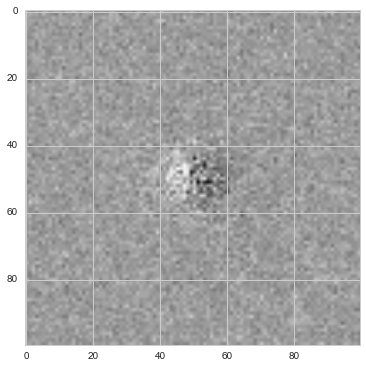

In [49]:
_, _, z = genDipole(psfWidth=5.)
plt.imshow(z)

In [50]:
img = getDipoleExposure(z, psfWidth=5.)
psf = img.getPsf()
arr = psf.computeImage().getArray()
print arr.min(), arr.max()
#plt.imshow(arr)

3.21225130365e-18 0.00536100862881


In [53]:
pk = psf.computePeak()
print pk
shp = psf.computeShape()
print shp
type(shp)
print shp.getDeterminantRadius()
print shp.getTraceRadius()

0.00536100862881
(ixx=28.8053296986, iyy=28.8053296986, ixy=-0.0)
5.36705968838
5.36705968838


In [52]:
np.sqrt(28.805329698)

5.3670596883209711